In [1]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
ps = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

link = 'documents.xlsx'
df = pd.ExcelFile(link).parse('general_labeled')

df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

In [2]:
df_filtered = df
df_filtered["ns_label_merged"].replace(['No interest in a T-shirt', 
                                                  'Value alignment', 
                                                  'Non-value-related (price, product, business, quality etc.)', 
                                                  'Nonsense/Confusion/Non-classified', 
                                                  'Describing comparing Beliefs',
                                                'Value alignment and associated process'], ['No Interest', 'Value Alignment', 'Non-value_related', 'Confusion', 'Describing Beliefs',
                                                                                             'Value Alignment+'], inplace=True)

/var/folders/qw/h5qjjyx57sn6pb8_hv0_3_600000gn/T/ipykernel_15921/3928920030.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered["ns_label_merged"].replace(['No interest in a T-shirt',


In [3]:
le.fit(list(df_filtered["ns_label_merged"]))

LabelEncoder()

In [4]:
df_filtered["ns_label_merged (encoded)"] = le.transform(df_filtered["ns_label_merged"])
df_filtered = df_filtered[["ns_label_merged", "ns_label_merged (encoded)", "narratives_self"]]

In [5]:
train = df_filtered.sample(frac=0.8, random_state=42).sort_index()
train['narratives_self'] = train['narratives_self'].apply(lambda x: ' '.join(ps.stem(w) for w in x.split()))
train.head()

,ns_label_merged,ns_label_merged (encoded),narratives_self
0,No Interest,2,"i person do not want that t-shirt, nor do i ne..."
2,Non-value_related,3,i felt that it didn't matter to me too much ab...
3,Confusion,0,"i must admit, i wa rather confused. i couldn't..."
5,Confusion,0,just a guess
6,Describing Beliefs,1,peopl take these survey are gener poor and fra...


In [6]:
test = df_filtered[~df_filtered.index.isin(train.index)]
test['narratives_self'] = test['narratives_self'].apply(lambda x: ' '.join(ps.stem(w) for w in x.split()))

/var/folders/qw/h5qjjyx57sn6pb8_hv0_3_600000gn/T/ipykernel_15921/1195483364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['narratives_self'] = test['narratives_self'].apply(lambda x: ' '.join(ps.stem(w) for w in x.split()))


In [7]:
desc_vectorizer = CountVectorizer(analyzer="word", max_features=800)
training_bag_of_words = desc_vectorizer.fit_transform(train["narratives_self"])
x_train = pd.DataFrame(training_bag_of_words.toarray(),
                       columns=[x for x in desc_vectorizer.get_feature_names_out()]).astype(int)

In [8]:
test_bag_of_words = desc_vectorizer.transform(test["narratives_self"])
x_test = pd.DataFrame(test_bag_of_words.toarray(),
                      columns=[x for x in desc_vectorizer.get_feature_names_out()]).astype(int)

In [9]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, train["ns_label_merged (encoded)"])

RandomForestClassifier(random_state=42)

In [10]:
def analysis_result(model_name, 
                    train_prediction,
                    train_target,
                    test_prediction, 
                    test_target):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
    
    results = dict()
    results["model"] = model_name
    results["train_accuracy"] = accuracy_score(train_prediction, train_target)
    results["balanced_train_accuracy"] = balanced_accuracy_score(train_prediction, train_target)
    results["train_precision"] = precision_score(train_target, train_prediction, average='weighted', zero_division=0)
    results["train_recall"] = recall_score(train_target, train_prediction, average='weighted', zero_division=0)
    results["test_accuracy"] = accuracy_score(test_prediction, test_target)
    results["balanced_test_accuracy"] = balanced_accuracy_score(test_prediction, test_target)
    results["test_precision"] = precision_score(test_target, test_prediction, average='weighted', zero_division=0)
    results["test_recall"] = recall_score(test_target, test_prediction, average='weighted', zero_division=0)

    for key, value in results.items():
        if isinstance(value, str):
            print(f"\n{value}")
        else:
            print(f"\t{key}: {'{:.2f}'.format(value)}")
    
    return results

In [11]:
accumulated_results = []

train_pred_rf = rf.predict(x_train)
test_pred_rf = rf.predict(x_test)

accumulated_results.append(analysis_result("Random Forest", 
                                           train_pred_rf, 
                                           train['ns_label_merged (encoded)'],
                                           test_pred_rf, 
                                           test['ns_label_merged (encoded)']))


Random Forest
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	train_precision: 1.00
	train_recall: 1.00
	test_accuracy: 0.59
	balanced_test_accuracy: 0.61
	test_precision: 0.62
	test_recall: 0.59


In [12]:
actual_labels = le.inverse_transform(test_pred_rf)

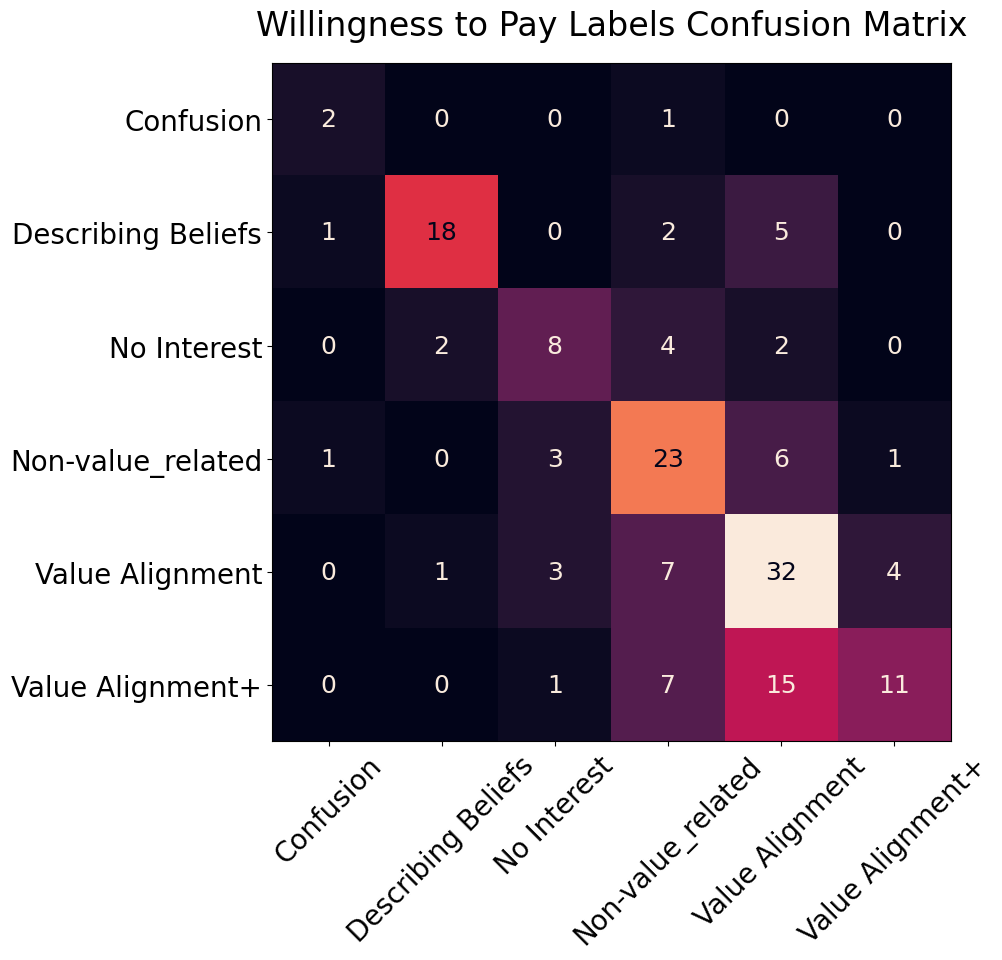

In [13]:
cm = confusion_matrix(test['ns_label_merged'],
                      actual_labels,
                      labels=le.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

rocket_cmap = sns.color_palette("rocket", as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=rocket_cmap, xticks_rotation=45, ax=ax, colorbar=False,)

plt.title("Confusion Matrix", pad=20)

ax.set_xlabel("")
ax.set_ylabel("")

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

for txt in disp.text_.flat:
    txt.set_fontsize(18)

ax.set_title("Willingness to Pay Labels Confusion Matrix", fontsize=24, pad=20)

plt.tight_layout()
plt.show()

In [14]:
test["predicted_ns_label"] = actual_labels

/var/folders/qw/h5qjjyx57sn6pb8_hv0_3_600000gn/T/ipykernel_15921/2107407266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_ns_label"] = actual_labels


/var/folders/qw/h5qjjyx57sn6pb8_hv0_3_600000gn/T/ipykernel_15921/1046399870.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")


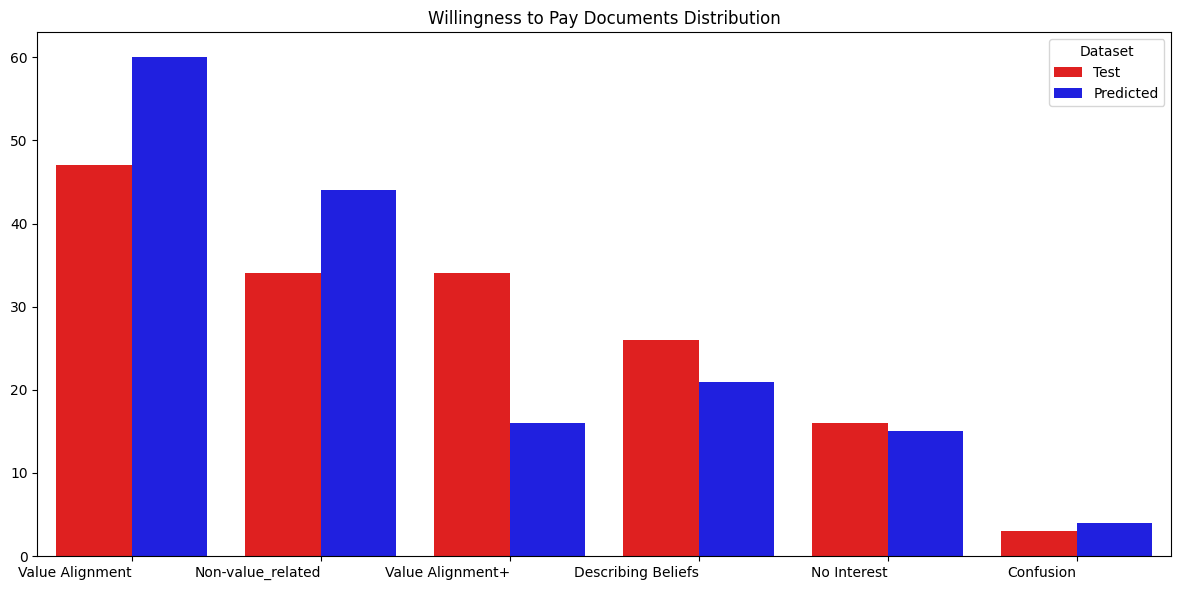

In [15]:
accumulated = pd.concat([
    test["ns_label_merged"].value_counts(),
    test["predicted_ns_label"].value_counts()
], axis=1, sort=False, keys=["Test", "Predicted"])

df_long = (
    accumulated
    .reset_index()
    .melt(id_vars="index", value_vars=["Test", "Predicted"],
          var_name="Dataset", value_name="Count")
    .rename(columns={"index": "Category"})
)

custom_colors = ["#FF0000", "#0000FF"]

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=df_long,
    x="Category", y="Count", hue="Dataset",
    palette=custom_colors
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_title("Willingness to Pay Documents Distribution")

ax.set_xlabel("")
ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [16]:
test[ 
    (test['predicted_ns_label'] != "Value alignment and associated process") & 
    (test['ns_label_merged'] == "Value alignment and associated process")
][["narratives_self", "ns_label_merged", "predicted_ns_label"]].to_csv("misclassified_top_ns_bow+rf.csv", index=False)

### Neural Network

In [17]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model.fit(x_train, train["ns_label_merged (encoded)"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [18]:
train_pred_xgb = model.predict(x_train)
test_pred_xgb = model.predict(x_test)

accumulated_results.append(analysis_result("XGBoost", 
                                           train_pred_xgb, 
                                           train['ns_label_merged (encoded)'],
                                           test_pred_xgb, 
                                           test['ns_label_merged (encoded)']))


XGBoost
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	train_precision: 1.00
	train_recall: 1.00
	test_accuracy: 0.53
	balanced_test_accuracy: 0.50
	test_precision: 0.55
	test_recall: 0.53
